# Advanced Audio Processing in ASR
In this tutorial, we will cover different ways to process audio in ASR, and also why and when we will need to implement and incorporate these techniques.

### Why process audio
- Audio can come with many imperfections and artifacts
- This can commonly come in the form of noise

Our ML models are very sensitive to the noise in the data, and unnecessary noise can lead to drop in model accuracy. (i.e. [The cocktail problem](https://en.wikipedia.org/wiki/Cocktail_party_effect))

This is especially so in ASR models, where unintended noise can obscure pronounciations or make transcription harder.

Therefore, to ensure that the model is able to handle noisy data well, we should handle noise during training time and inference time.

In [1]:
!pip install datasets
!pip install librosa
!pip install soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import Audio
import soundfile as sf
from tqdm.notebook import tqdm

# Uncomment the following if you want to use HuggingFace for ASR later
# from transformers import pipeline

# For reproducibility
np.random.seed(42)

### Visualisation

The following two cells below initialise the function for visualisation of the data

In [5]:
def load_and_plot_audio(file_path, sr=16000):
    """Load audio and display waveform and spectrogram"""
    y, sr = librosa.load(file_path, sr=sr)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    return y, sr

In [15]:
# Visualisation code
def visualize_audio_enhancement(original_audio, enhanced_audio, sr,
                               titles=None, n_fft=2048, figsize=(14, 8)):
    """
    Visualize original and enhanced audio with waveforms and spectrograms.

    Parameters:
    -----------
    original_audio : ndarray
        Original audio signal
    enhanced_audio : ndarray
        Enhanced audio signal
    sr : int
        Sample rate
    titles : dict, optional
        Dictionary containing custom titles with keys:
        'figure', 'original_wave', 'enhanced_wave', 'original_spec', 'enhanced_spec'
    n_fft : int, optional
        FFT size for spectrogram calculation
    figsize : tuple, optional
        Figure size (width, height) in inches

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object for further customization if needed
    """
    # Default titles
    default_titles = {
        'figure': 'Audio Enhancement Visualization',
        'original_wave': 'Original Audio',
        'enhanced_wave': 'Enhanced Audio',
        'original_spec': 'Original Spectrogram',
        'enhanced_spec': 'Enhanced Spectrogram'
    }

    # Use provided titles or defaults
    if titles is None:
        titles = default_titles
    else:
        # Fill in any missing titles with defaults
        for key in default_titles:
            if key not in titles:
                titles[key] = default_titles[key]

    # Create figure
    fig = plt.figure(figsize=figsize)
    if 'figure' in titles:
        fig.suptitle(titles['figure'], fontsize=16)

    # Waveforms
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(original_audio, sr=sr)
    plt.title(titles['original_wave'])
    plt.xlabel('Time (s)')

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(enhanced_audio, sr=sr)
    plt.title(titles['enhanced_wave'])
    plt.xlabel('Time (s)')

    # Spectrograms
    plt.subplot(2, 2, 3)
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(original_audio, n_fft=n_fft)), ref=np.max)
    librosa.display.specshow(D_original, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(titles['original_spec'])

    plt.subplot(2, 2, 4)
    D_enhanced = librosa.amplitude_to_db(np.abs(librosa.stft(enhanced_audio, n_fft=n_fft)), ref=np.max)
    librosa.display.specshow(D_enhanced, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(titles['enhanced_spec'])

    plt.tight_layout()

    return fig


### Spectral Subtraction
Spectral subtraction is a classic technique used to enhance speech before feeding it to
ASR models. While modern ASR systems are more robust to noise, preprocessing can still
help in challenging acoustic environments.

**Why spectral subtraction?**
1. Can increase ASR accuracy in noisy conditions
1. Is computationally efficient
1. Helps us understand the spectral properties of speech vs. noise

Let's implement this technique using Librosa, a modern audio processing library.

In [20]:
#Load data

data = load_dataset("jlvdoorn/atco2-asr-atcosim", streaming = True)

audio = next(iter(data['train']))['audio']

### Visualise Audio File

In [8]:
#Observe that the data is noisy
Audio(audio['array'], rate=audio['sampling_rate'])

### How does Spectral Subtraction Work?

A key assumption made in spectral subtraction is that the noise and the audio are additive in nature. This means that if we can compute the noise spectrum, we can easily subtract it from the real audio that we want.


In [17]:
def spectral_subtraction(signal, noise_sample, sr, n_fft=2048, hop_length=512, alpha=2.0, beta=0.01):
    """
    Apply spectral subtraction to remove noise from a signal

    Parameters:
    -----------
    signal : ndarray
        The noisy input signal
    noise_sample : ndarray
        Sample of noise to use for estimation
    sr : int
        Sample rate
    n_fft : int
        FFT size
    hop_length : int
        Hop length for STFT
    alpha : float
        Oversubtraction factor (1.0-3.0)
    beta : float
        Spectral floor parameter (0.001-0.1)
    """
    # Compute Short Time Fourier Transform (STFT) of signal
    #This is done to break the audio into multiple smaller windows of audio
    #Allows us to analyze segments where the properties are relatively constant
    signal_stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    #We compute the power representation
    #(Key Idea: Noise and audio add linearly for uncorrelated signals in power repr.)
    signal_power = np.abs(signal_stft)**2

    # Compute noise power spectrum
    #We do this by taking a sample of the audio where only the noise is present
    noise_stft = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop_length)
    noise_power = np.abs(noise_stft)**2
    mean_noise_power = np.mean(noise_power, axis=1, keepdims=True)

    # Perform spectral subtraction
    # alpha is a oversubtraction factor, to elp control for more complete noise removal
    subtracted_power = signal_power - alpha * mean_noise_power

    # Apply spectral floor
    # The subtraction could lead to negative values, which is invalid
    # We do a floor here to ensure all the audio samples remain consistent, and
    # are not inaudible
    subtracted_power = np.maximum(subtracted_power, beta * signal_power)

    # Convert back from power representation
    enhanced_mag = np.sqrt(subtracted_power)

    # Apply original phase to help construct back to signal
    enhanced_stft = enhanced_mag * np.exp(1j * np.angle(signal_stft))

    # Inverse STFT --> Construct back to audio from fourier transform
    enhanced_signal = librosa.istft(enhanced_stft, hop_length=hop_length, length=len(signal))

    return enhanced_signal

In [18]:
# Extract noise sample from the first 0.5 seconds
audio_array = audio['array']
sr = audio['sampling_rate']
noise_duration = 0.5
noise_sample = audio_array[:int(noise_duration * sr)]

# Apply spectral subtraction
enhanced_signal = spectral_subtraction(
    audio_array,
    noise_sample,
    sr=sr,
    n_fft=2048,
    hop_length=512,
    alpha=2.0,  # Adjust based on noise level
    beta=0.01   # Adjust to control musical noise
)


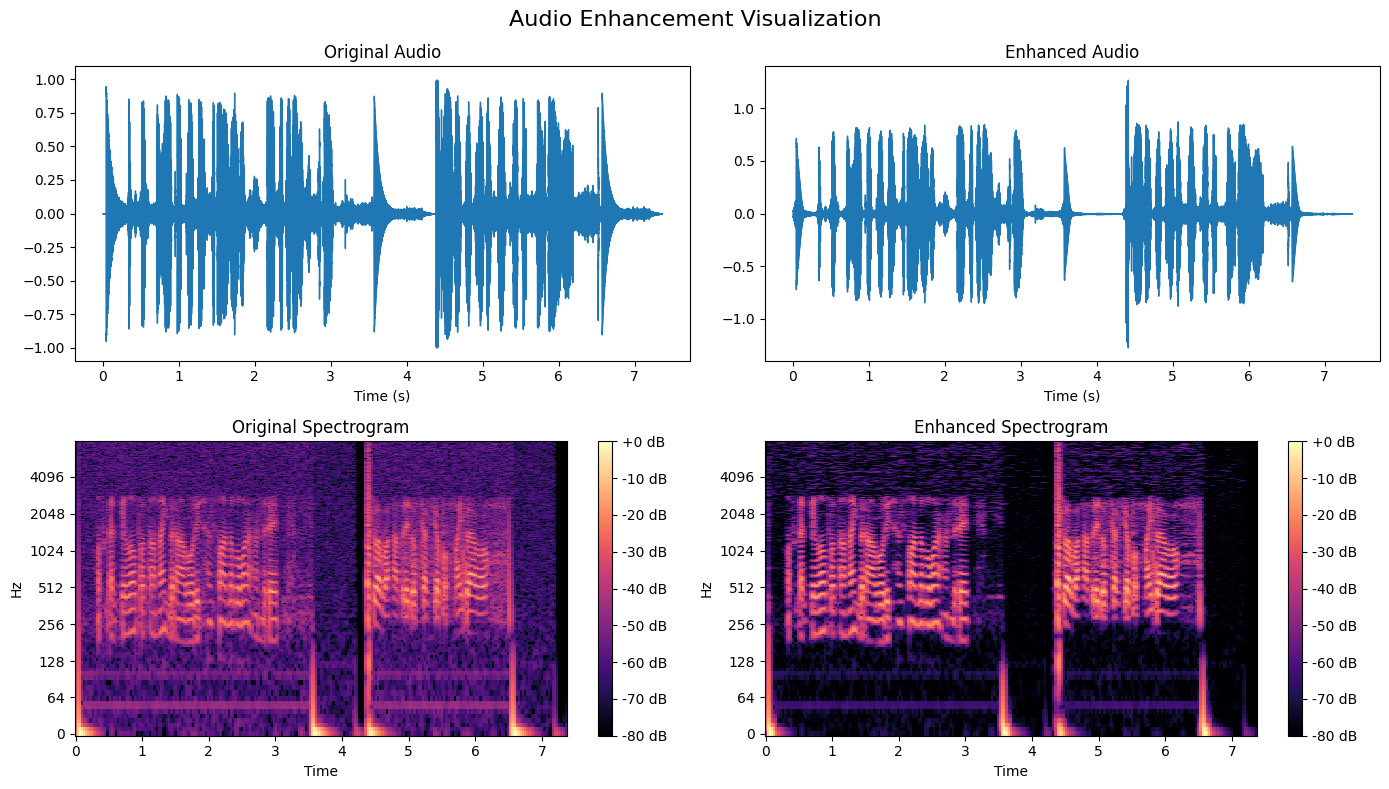

In [21]:
visualize_audio_enhancement(audio_array,enhanced_signal,sr)
plt.show()

### How to check if noise was removed
See how grainy the original spectrogram was, and compare that to the much clearer processed spectrogram.

You can also listen to the enhanced audio.

In [12]:
#Finally, show the enhanced audio
Audio(enhanced_signal, rate=sr)

#Notice that spectral subtraction did not remove the spiky noise in the middle,

### Deep Learning Methods

Sometimes, there might be very complex noise that cannot be filtered using traditional methods effectively. This is when we rely on deep learning modules to help preprocess the audio. For example, the noise spike in the middle of the audio is one example of something spectral subtraction did not remove.

We will use the `speechbrain` library to preprocess our audio

In [13]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
#Deep Neural Network Version (Using SpeechBrain)

from speechbrain.inference.enhancement import SpectralMaskEnhancement
import torchaudio
import torch
import os

# Make sure we have a proper directory for downloading pretrained models
os.makedirs("pretrained_models", exist_ok=True)

# Load the MetricGAN+ model for spectral mask enhancement
model = SpectralMaskEnhancement.from_hparams(
    source="speechbrain/metricgan-plus-voicebank",
    savedir='pretrained_models/metricgan-plus-voicebank'
)


# Ensure the sample rate is compatible with the model (usually 8kHz for sepformer-wham)
if sr != 16000:
    brain_audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=16000)
    sr = 16000

# Save as temporary file for the model
temp_file = "temp_atc_audio.wav"
audio_tensor = torch.tensor(audio_array).unsqueeze(0)
torchaudio.save(temp_file, audio_tensor, sr)

# Process with SpeechBrain using enhance_file
print("Processing with SpeechBrain SpectralMask model...")
enhanced_speech = model.enhance_file(filename=temp_file)
Audio(enhanced_speech, rate = 16000)

# Notice that it removes the noise and the spike in the miidle!

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/metricgan-plus-voicebank' if not cached


hyperparams.yaml:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--metricgan-plus-voicebank/snapshots/a196ce26b3bdace6fa1d819017584bdbcce462a8/hyperparams.yaml' -> '/content/pretrained_models/metricgan-plus-voicebank/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/metricgan-plus-voicebank' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/metricgan-plus-voicebank.
INFO:speechbrain.utils.fetching:Fetch enhance_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/metricgan-plus-voicebank' if not cached


enhance_model.ckpt:   0%|          | 0.00/7.59M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--metricgan-plus-voicebank/snapshots/a196ce26b3bdace6fa1d819017584bdbcce462a8/enhance_model.ckpt' -> '/content/pretrained_models/metricgan-plus-voicebank/enhance_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["enhance_model"] = /content/pretrained_models/metricgan-plus-voicebank/enhance_model.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: enhance_model
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): enhance_model -> /content/pretrained_models/metricgan-plus-voicebank/enhance_model.ckpt


Processing with SpeechBrain SpectralMask model...
